<ipython-input-2-b12100146ab7>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['BODY_TYPE'] = clean_data['MODEL'].map(df2.set_index('MODEL')['BODY_TYPE'])
C:\Users\varun\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\varun\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


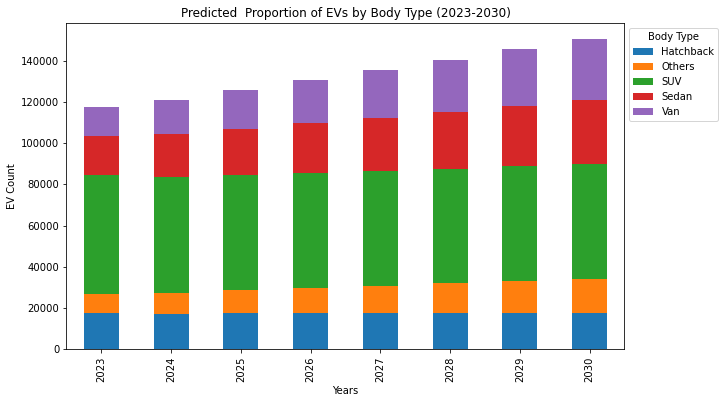

In [2]:
######### 4_2 Predicted Proportion of EVs by Body Type (2023-2030)  #########

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA

# Replace 'url_to_your_csv_file' with the raw GitHub URL of your CSV file
csv_url = r'https://raw.githubusercontent.com/varunraaju/Battery_Cycle_Plots/main/4_2/VEH0171b_GenModels.csv?token=GHSAT0AAAAAACFKR6ACCF667H4XWG2K3EWAZGI5MEQ'

# Read the CSV file into a DataFrame, skipping the first 4 rows
df = pd.read_csv(csv_url, skiprows=4)

# Save the first four columns in a separate DataFrame with the renamed names
first_four_columns = df.iloc[:, :6].rename(columns={df.columns[2]: 'BODY TYPE', df.columns[3]: 'MAKE', df.columns[4]: 'MODEL', df.columns[5]: 'FUEL'})

# Drop the first two columns from the original DataFrame
df.drop(df.columns[:4], axis=1, inplace=True)

# Create a new DataFrame to store the sums
sum_df = pd.DataFrame(index=df.index)

# Iterate through columns and group by left 4 characters of the header
for col in df.columns:
    header_prefix = col[:4]
    if header_prefix not in sum_df.columns:
        selected_columns = df.loc[:, df.columns.str[:4] == header_prefix]
        sum_df[header_prefix] = pd.to_numeric(selected_columns.stack(), errors='coerce').groupby(level=0).sum()

# Print the first few rows of the new DataFrame with sums and the first four columns unchanged
result_df = pd.concat([first_four_columns, sum_df], axis=1)
new_df = result_df.drop(result_df.columns[[0, 1,6, 7]], axis=1)

# Calculate the sum of numbers from the 5th column till the last column and add a new "TOTAL" column
new_df['TOTAL'] = new_df[new_df.columns[2:]].sum(axis=1)

# Filter out rows where 'MODEL' column contains the string "MISSING"
clean_data = new_df[~new_df['MODEL'].str.contains("MISSING")]
# print(clean_data)
##################################################################
# Manually replace the EV battery capacity data file path

csv_url2 = r'https://raw.githubusercontent.com/varunraaju/Battery_Cycle_Plots/main/4_2/EV_CAPACITY.csv?token=GHSAT0AAAAAACFKR6AC3N7FNLYMPDUNBHUEZGI5MTA'
df2 = pd.read_csv(csv_url2)

###################################################################
######### Plot Code ###########
# merging both the data frames
df2.columns = df2.columns.str.upper()

clean_data['BODY_TYPE'] = clean_data['MODEL'].map(df2.set_index('MODEL')['BODY_TYPE'])
clean_data = clean_data.dropna(subset=['BODY_TYPE'])
# Drop rows with NaN values in the 'BODY_TYPE' column


# List of body types to categorize
main_body_types = ['Sedan', 'SUV', 'Hatchback', 'Van']

# Categorize 'BODY TYPE' column as Sedan, SUV, Hatchback, Van, and "Others"
clean_data['BODY_TYPE_CATEGORIZED'] = clean_data['BODY_TYPE'].where(clean_data['BODY_TYPE'].isin(main_body_types), 'Others')
# List of columns from 2016 to 2022
year_columns = ['2018', '2019', '2020', '2021', '2022']

# Group by 'BODY_TYPE' and sum the columns from 2016 to 2022
grouped_data = clean_data.groupby('BODY_TYPE_CATEGORIZED')[year_columns].sum().reset_index()

# print(grouped_data)

df = grouped_data
############################################################

# Transpose the data to have years as columns
transposed_data = df.set_index('BODY_TYPE_CATEGORIZED').T

# Convert values to float for forecasting
transposed_data = transposed_data.astype(float)

# Years to forecast
years_forecast = np.arange(2023, 2031)

# Perform linear regression for each body type and forecast the values for the years 2023 to 2030
for col in transposed_data.columns:
    y = transposed_data[col].values[:5].reshape(-1, 1)

    model = LinearRegression()
    model.fit(np.arange(2018, 2023).reshape(-1, 1), y)

    y_forecast = model.predict(years_forecast.reshape(-1, 1))

    forecast_col = pd.Series(y_forecast.flatten(), index=years_forecast)
    transposed_data[col] = pd.concat([transposed_data[col], forecast_col], axis=0)

# Convert the forecasted years to integers (column names are kept as strings)
transposed_data.columns = transposed_data.columns.astype(str)

# Transpose the data back to its original form
forecasted_data = transposed_data.T.reset_index()
forecasted_data.rename(columns={'index': 'BODY_TYPE_CATEGORIZED'}, inplace=True)

df.set_index('BODY_TYPE_CATEGORIZED', inplace=True)

# Function to fit ARIMA model and forecast future values
def forecast_arima(series, order, forecast_steps):
    model = ARIMA(series, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=forecast_steps)
    return forecast

# Forecast for future years (2023 to 2027)
years_to_forecast = 8
forecast_years = [str(2022 + i) for i in range(1, years_to_forecast + 1)]

# Perform forecasting for each category
forecasts = {}
for category in df.index:
    series = df.loc[category].values
    forecast = forecast_arima(series, order=(1, 1, 1), forecast_steps=years_to_forecast)
    forecasts[category] = forecast

# Create a DataFrame to store the forecasts
forecast_df = pd.DataFrame(forecasts, index=forecast_years)

# print(forecast_df)

# Years
years = range(2023, 2031)

# Plot stacked bar graphs
ax = forecast_df.plot(kind='bar', stacked=True, figsize=(10, 6))

# Set the title and labels
plt.title("Predicted  Proportion of EVs by Body Type (2023-2030)")
plt.xlabel("Years")
plt.ylabel("EV Count")

# Add a legend
plt.legend(title='Body Type', loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

